# Split up test results into tp_gt, tp_pred, fp_pred, fn_gt

We are interested in ways in which the network messes up. One way to investigate this is by checking what the raw data looks like when the network makes a mistake. It is also of interest to see what the raw data looks like when the network does well.

To do this we need to align the raw data from each segmented object. We do this by taking the segmentations (either ground truth or predicted) and fitting a line to their voxels. Once we have the lines for each object, we can determine the rotation matrix to align them all to a single line, e.g. (0,0,1). We can then apply that rotation matrix to each objects corresponding raw data. 

The alignment step requires that - for each object - we have its center of mass, and bounding box. The rest of this code assumes you have your data split up into the following datasets: tp_gt, tp_pred, fp_pred, fn_gt and that you have the corresponding bounding box and center of mass information.

# Fit Lines to Segmentations
Here we fit lines to the predicted segmentations. To do so we first must run some analysis code to find the bounding box of each corresponding to true positive, false positive etc. This is in a separate repo but could also be done here. We then look at each segmentated object one at a time and fit a line to its voxels. We then project all these voxels along this line to find the extents of the line to make it a line segment. We then write this out as neuroglancer annotations. You can also write these out however you would like, you would just have to update the downstream code accordingly.

In [ ]:
import numpy as np
from neuroglancer.write_annotations import AnnotationWriter
from neuroglancer import AnnotationPropertySpec
from neuroglancer.coordinate_space import CoordinateSpace
import numpy as np
import numpy as np
from funlib.geometry import Roi
from funlib.persistence import open_ds
import pandas as pd
from tqdm import tqdm


def find_min_max_projected_points(points, line_point, line_direction):
    # chatgpt
    line_direction = line_direction / np.linalg.norm(
        line_direction
    )  # Normalize direction vector

    # Calculate the vector from line_point to each point
    point_vectors = points - line_point

    # Calculate the projection scalar for each point using dot product and broadcasting
    projection_scalars = np.sum(point_vectors * line_direction, axis=1)

    # Calculate the projected points for each point
    projected_points = line_point + projection_scalars[:, np.newaxis] * line_direction

    # Find the minimum and maximum projection scalar indices
    min_projection_idx = np.argmin(projection_scalars)
    max_projection_idx = np.argmax(projection_scalars)

    return projected_points[min_projection_idx], projected_points[max_projection_idx]


dataset = "jrc_22ak351-leaf-3m"
run = "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
iteration = "140000"
yaml_name = f"{dataset}_2023-12-06"

# since it is arbitrary to have endpoints for line segment in terms of fitting, will just fit a line and then truncate it
for ds_name in ["tp_gt", "tp_pred", "fn_gt", "fp_pred"]:
    annotation_writer = AnnotationWriter(
        CoordinateSpace(names=("x", "y", "z"), scales=(1, 1, 1), units="nm"),
        annotation_type="line",
        properties=[
            AnnotationPropertySpec(id="identifier", type="uint16"),
        ],
    )
    df = pd.read_csv(
        f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/analysisResults/{yaml_name}/{ds_name}.csv"
    )
    ds = open_ds(
        f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5", ds_name
    )
    # uu, dd, vv = np.linalg.svd(data - datamean, full_matrices=False)
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # object id, bounding box and center of mass information, calculated beforehand
        id = row["Object ID"]
        cube_min = np.array([row[f"MIN {d} (nm)"] for d in ["Z", "Y", "X"]])
        cube_max = np.array([row[f"MAX {d} (nm)"] for d in ["Z", "Y", "X"]])
        com = np.array([row[f"COM {d} (nm)"] for d in ["Z", "Y", "X"]])

        # define an roi to actually ecompass the bounding box
        roi = Roi(cube_min - 8, (cube_max - cube_min) + 16)

        # only look at pixels corresponding to current object
        data = np.column_stack(np.where(ds.to_ndarray(roi) == id))

        # fit line to object voxels
        uu, dd, vv = np.linalg.svd(data - np.mean(data, axis=0), full_matrices=False)
        line_direction = vv[0]
        line_origin = com

        # find endpoints of line segment so that we can write it as neuroglancer annotations
        start_point, end_point = find_min_max_projected_points(
            data * 8 + 4 + roi.begin, line_origin, line_direction
        )

        # write out lines as neuroglancer annotations
        annotation_writer.add_line(
            point_a=start_point[::-1],
            point_b=end_point[::-1],
            id=int(id),
            identifier=int(id),
        )

    annotation_writer.write(
        f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/leaf-gall/forAnnotators/{yaml_name}/{ds_name}"
    )

# Align Segmentations
Here we read in the fitted line annotations and calculate the rotation matrix to align the fitted lines to [0,0,1]. We take those rotation matrices and the resepective raw data corresponding to each fitted line and align rotate/align the raw data and write it out.

In [ ]:
import dask.diagnostics
import dask.array as da
from dask.distributed import Client
import numpy as np
from funlib.persistence import open_ds
from funlib.geometry import Roi
import numpy as np
from funlib.geometry import Roi
import scipy
from funlib.persistence import open_ds
from utils.utils import get_rotation_matrix, extract_precomputed_annotations
from funlib.persistence import prepare_ds
from funlib.geometry import Coordinate, Roi

# Info to get paths
dataset = "jrc_22ak351-leaf-3m"
yaml_name = f"{dataset}_2023-12-06"

ds = open_ds(
    f"/nrs/cellmap/data/{dataset}/{dataset}.n5",
    "/em/fibsem-uint8/s0",
)


pad = 60  # want this to be the cube size, but we need to make sure that all rotated cubes contain voxels in this region even when rotated, so we need this larger cubes
extra_pad = int(np.ceil(np.sqrt(3) * pad))


@dask.delayed
def read_and_align_image(current_pd):
    pd_start = current_pd[:3]
    pd_end = current_pd[3:]
    pd_center = np.round(0.5 * (pd_start + pd_end) / 8) * 8
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    v1 = pd_start - pd_end
    # v1 = np.array([1, 0, 0])
    v2 = np.array([0, 0, 1])
    rot = get_rotation_matrix(v1, v2)

    roi = Roi((pd_center - extra_pad * 8)[::-1], [(extra_pad * 2 + 1) * 8] * 3)
    im = ds.to_ndarray(roi).swapaxes(0, 2)
    # Translation matrix to shift the image center to the origin
    x, y, z = im.shape
    trans = np.array((-x / 2, -y / 2, -z / 2))

    T = np.identity(4)
    T[:3, -1] = trans
    im = scipy.ndimage.affine_transform(
        im, np.linalg.inv(np.linalg.inv(T).dot(rot).dot(T)), order=0
    )
    im = im[
        extra_pad - pad : extra_pad + pad + 1,
        extra_pad - pad : extra_pad + pad + 1,
        extra_pad - pad : extra_pad + pad + 1,
    ]
    return da.from_array(im)


# Loop over the datasets
for ds_name in ["tp_gt", "tp_pred", "fn_gt", "fp_pred"]:
    with Client(threads_per_worker=1, n_workers=1) as client:
        client.cluster.scale(10)
        print(client.dashboard_link.replace("127.0.0.1", "ackermand-ws2.hhmi.org"))

        # Extract neuroglancer annotations as numpy array
        _, pds = extract_precomputed_annotations(
            f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/leaf-gall/forAnnotators/{yaml_name}/{ds_name}"
        )

        # Align the images
        aligned_images = [
            da.from_delayed(
                read_and_align_image(current_pd),
                (extra_pad * 2 + 1, extra_pad * 2 + 1, extra_pad * 2 + 1),
                np.float64,
            )
            for current_pd in pds
        ]
        # Stack all small Dask arrays into one
        stack = da.stack(aligned_images, axis=0)
        composite_image = stack.mean(axis=0).compute()

        roi = Roi((0, 0, 0), np.array(composite_image.shape) * 8)
        output_ds = prepare_ds(
            f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5",
            f"composite_images/{ds_name}",
            total_roi=roi,
            voxel_size=np.array([8, 8, 8]),
            dtype=np.uint8,
            write_size=Coordinate(3 * [8 * 128]),
        )
        output_ds[roi] = composite_image

/tmp/ipykernel_655078/334287682.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  yz_intercept = (0, -direction[1] / direction[0], -direction[2] / direction[0])


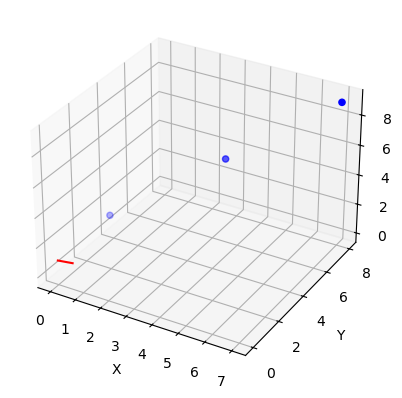

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def fit_line_to_points(points):
    # Convert points to numpy array
    points_array = np.array(points)

    # Center the data
    centered_points = points_array - np.mean(points_array, axis=0)

    # Perform Singular Value Decomposition
    _, _, vt = np.linalg.svd(centered_points)

    # The last row of V (or last column of V transposed) gives the direction of the best fit line
    direction = vt[-1]
    return direction


def find_intercepts(direction):
    # Intercepts on XY-plane (z=0)
    xy_intercept = (-direction[0] / direction[2], -direction[1] / direction[2], 0)

    # Intercepts on XZ-plane (y=0)
    xz_intercept = (-direction[0] / direction[1], 0, -direction[2] / direction[1])

    # Intercepts on YZ-plane (x=0)
    yz_intercept = (0, -direction[1] / direction[0], -direction[2] / direction[0])

    return xy_intercept, xz_intercept, yz_intercept


# Example data
points = [(1, 2, 3), (4, 5, 6), (7, 8, 9)]

# Calculate direction and intercepts
direction = fit_line_to_points(points)
xy_intercept, xz_intercept, yz_intercept = find_intercepts(direction)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the points
ax.scatter(*zip(*points), color="b")

# Plot the line
line_points = np.array([xy_intercept, xz_intercept, yz_intercept])
ax.plot(*line_points.T, color="r")

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [17]:
vt[-1]

NameError: name 'vt' is not defined